In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/MW-timestamp-NEW.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904964,3.051593126680745,905.0,929.5
air_temp,1587257,61.85144042834878,11.833623786835721,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970203971,0.0,359.0
avg_wind_speed,1586824,2.774272067979844,2.0607577935630355,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806429,0.0,359.0
max_wind_speed,1586824,3.3998134008569685,2.423167433617133,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077615,0.0,359.0
min_wind_speed,1586824,2.1331304542917913,1.745345084932679,0.0,32.0


In [5]:
dataDF.count()

1587257

In [6]:
#Down sample to take every 10th value
filtered = dataDF.filter((dataDF.rowID % 10) == 0)

In [7]:
filtered.count()

158726

In [8]:
#SELECT required columns and drop rows with NULL

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

workingDF = filtered.select(cols).na.drop()

In [9]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [10]:
#CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [11]:
workingDF.columns

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [12]:
#ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [13]:
#SCALE the dataset.

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)

# Fit the StandardScaler
scalerModel = scaler.fit(assembled)

# Normalize each feature
scaledData = scalerModel.transform(assembled)

In [14]:
scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [19]:
#Perform Clustering.

from pyspark.ml.clustering import KMeans
howManyClusters = 12

# Trains a k-means model.
kmeans  = KMeans(k=howManyClusters, seed = 1)
%time model = kmeans.fit(scaledData)

CPU times: user 3 ms, sys: 5 ms, total: 8 ms
Wall time: 6.65 s


In [20]:
%time transformed = model.transform(scaledData)

CPU times: user 1 ms, sys: 999 µs, total: 2 ms
Wall time: 10.9 ms


In [21]:
%time featuresAndPrediction = transformed.select("features", "prediction")

CPU times: user 1 ms, sys: 2 ms, total: 3 ms
Wall time: 30.7 ms


In [22]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|            10573|
|         1|            13422|
|         2|            14833|
|         3|            18638|
|         4|             4633|
|         5|            15793|
|         6|            11535|
|         7|            18995|
|         8|            25630|
|         9|            11968|
|        10|             2249|
|        11|            10411|
+----------+-----------------+



In [33]:
# Print cluster centers.

pd.DataFrame(model.clusterCenters(), columns = cols)

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,1.304318,-0.240301,-1.153878,1.733711,-1.046922,1.838704,-1.122005
1,0.157512,-0.743456,-1.219847,-0.549885,-1.070806,-0.565420,0.765232
2,-0.844086,-1.187147,0.359067,0.377051,0.485578,0.362212,1.350430
3,-0.225851,0.641771,0.409399,0.707502,0.518387,0.647364,-0.147868
4,0.131657,0.845997,1.893336,-0.628112,-1.547487,-0.554552,-0.753968
5,0.204733,-0.983129,0.642272,-0.548858,0.859580,-0.532304,1.168376
6,0.970906,0.235161,0.214661,-0.499573,0.402008,-0.503149,-0.808180
7,-0.617932,0.616826,0.133989,-0.619992,0.305342,-0.634391,-0.194565
8,0.284516,0.634947,-1.306414,-0.474168,-1.167003,-0.482872,-0.797559
9,0.133220,0.860683,1.373988,-0.638568,1.638270,-0.589493,-0.714741


In [34]:
# This function evaluates WSSE  -  Within Set Sum of Squared Errors.
from numpy import array
from math import sqrt

def wssse(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        return sqrt(sum([x*x for x in (point - center)]))
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [ ]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,31):
    #train kmeans
    print "Training for k = {} ".format(howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    model       = kmeans.fit(scaledData)
    transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    W = wssse(featuresAndPrediction, model)
    print "WSSSE = {} ".format(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

## Plots

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

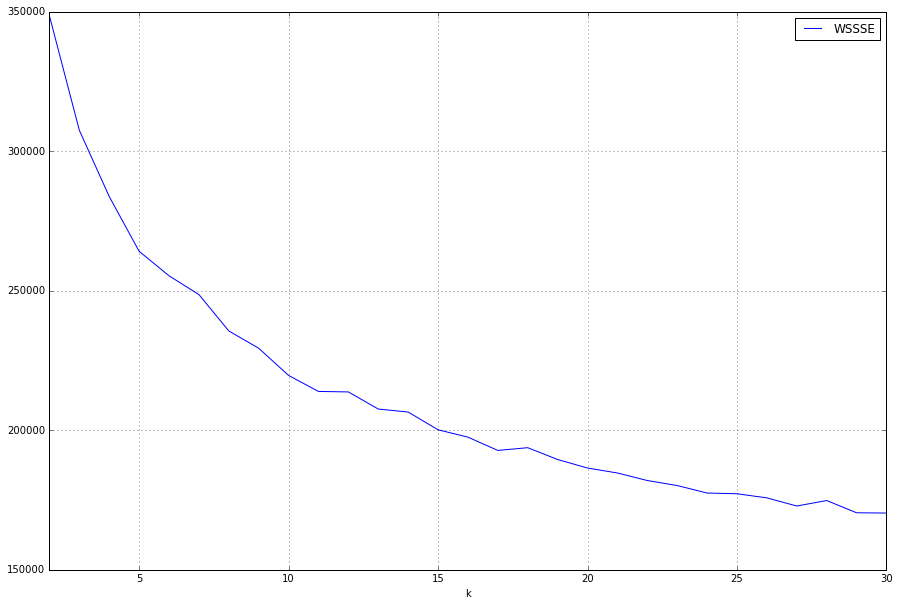

In [63]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True)

In [39]:
kmeans            = KMeans(k=11, seed = 1)
%time model       = kmeans.fit(scaledData)
%time transformed = model.transform(scaledData)
featuresAndPrediction     = transformed.select("features", "prediction")
W                 = wssse(featuresAndPrediction, model)
print(W)

CPU times: user 1 ms, sys: 7 ms, total: 8 ms
Wall time: 6.71 s
213931.099861


In [40]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [41]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [42]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)

In [43]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-1.143608,-0.882498,0.442351,1.938530,0.535035,1.897942,0.921724,0.0
1,0.235574,0.320827,1.887717,-0.652202,-1.551193,-0.577112,-0.284171,1.0
2,-0.237797,0.856418,-1.301769,-0.580907,-1.161884,-0.598166,-0.586259,2.0
3,0.286854,0.783609,1.330664,-0.632344,1.594514,-0.582801,-0.748623,3.0
4,-0.896779,-1.143427,0.366916,0.238478,0.468811,0.227791,1.342106,4.0
5,0.344960,-0.964678,0.662956,-0.534096,0.856779,-0.516286,1.086785,5.0
6,-0.177939,0.610278,0.406468,0.666915,0.515692,0.608831,-0.177008,6.0
7,-0.222971,0.600411,0.199593,-0.630223,0.375516,-0.643902,-0.398810,7.0
8,1.342904,-0.046006,-1.139442,-0.173248,-0.996086,-0.156849,-0.976423,8.0
9,1.197331,-0.249639,-1.154034,2.046549,-1.051449,2.160925,-1.129526,9.0


## Dry Days

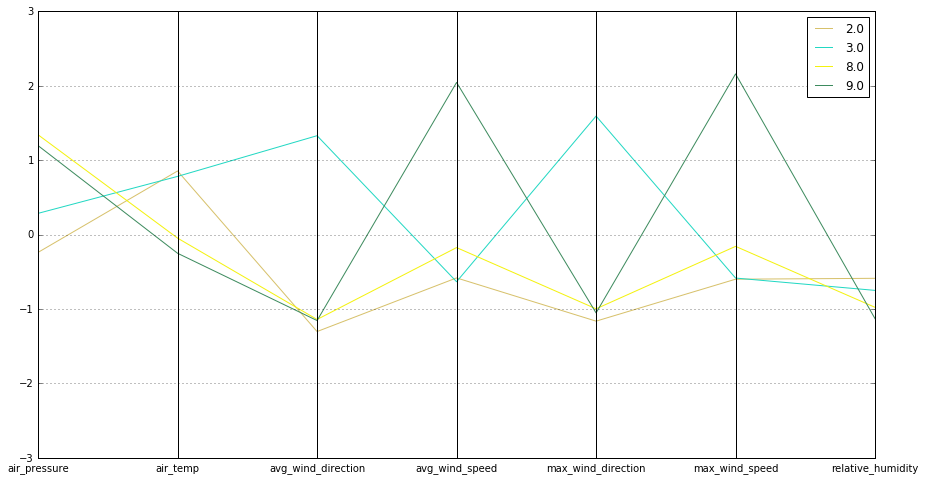

In [54]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['relative_humidity']< -0.5], 'prediction')

## Warm Days

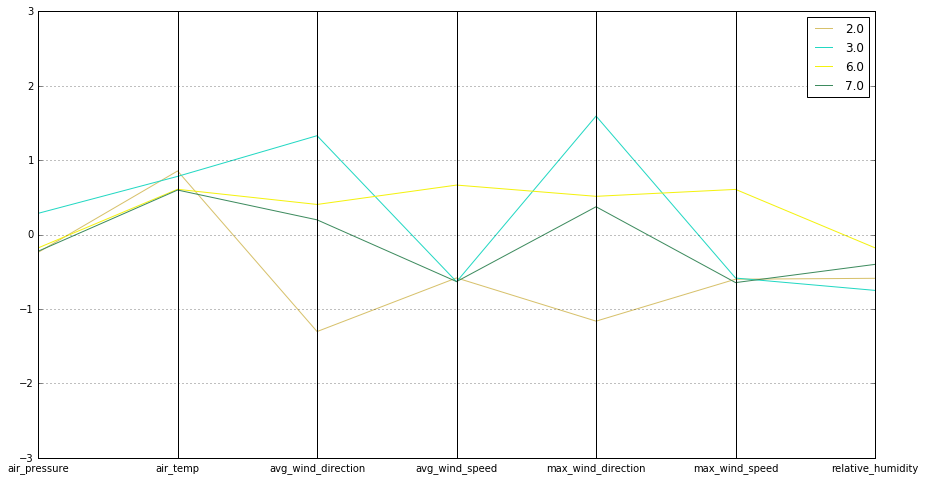

In [56]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['air_temp']> 0.5], 'prediction')

## Cool and Rainy Days

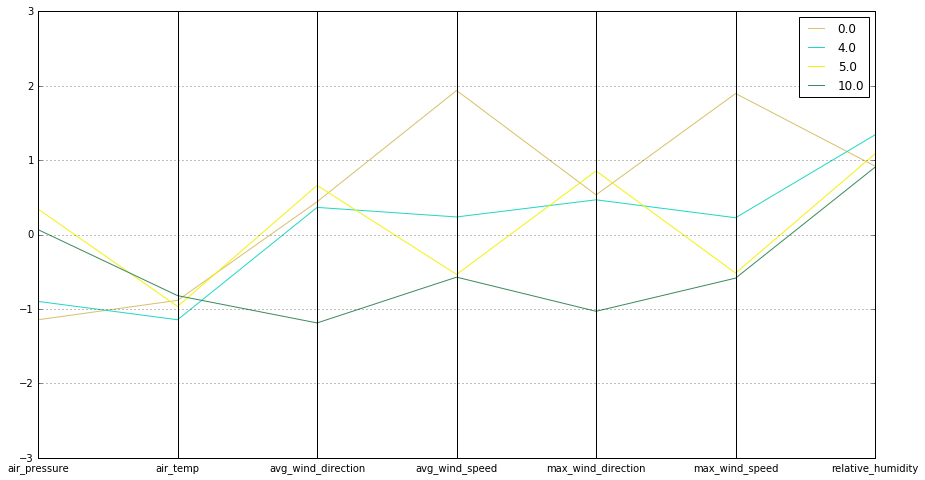

In [57]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[(P['relative_humidity']>0.5) & (P['air_temp']< 0.5)], 'prediction')